In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import joblib
import datetime as dt

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.models as models

#from skimage import io
import sklearn
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, f1_score, confusion_matrix, classification_report
from sklearn import metrics, preprocessing
from scipy.ndimage import zoom
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
import albumentations as A
import albumentations.pytorch
import wandb

#### Hyper Param Setting

In [2]:
CFG = {
    'fold_num': 5,
    'seed': 42,
    'model': 'resnet152',
    'img_size': 260,
    'epochs': 200,
    'train_bs':64,
    'valid_bs':64,
    'lr': 1e-4, ## learning rate
    'num_workers': 8,
    'verbose_step': 1,
    'patience' : 5,
    'label_encoder':False,
    'device': 'cuda:0',
    'freezing': False,
    'trainable_layer': 12,
    'model_path': './models'
}

#### wandb init

In [3]:
category = 'box'
time_now = dt.datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M")
project_name = 'KD_'+ CFG['model'] + '_' + category
user = 'hojunking'
run_name = project_name + '_' + run_id

In [4]:
# TRAIN DATASET DATAFRAME
train_path = '../Data/carbon_reduction_data/bin/train/'
label_list = ["box","untapedBox"]

train_img_paths = []
train_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}',end=' ')
    img_paths = [] 
    img_labels = []

    dir_path = train_path + label ## 레이블 폴더 경로
    
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
        for img in filenames: ## 각 파일 경로, 레이블 저장
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
        
    print(len(img_paths))

    train_img_paths.extend(img_paths)
    train_img_labels.extend(img_labels)

print('Train_Images: ',len(train_img_paths))
print("Train_Images_labels:", len(train_img_labels))

label: box 3919
label: untapedBox 1987
Train_Images:  5906
Train_Images_labels: 5906


In [5]:
# TEST DATASET DATAFRAME
test_path = '../Data/carbon_reduction_data/bin/test/'
test_img_paths = []
test_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}',end=' ')
    img_paths = [] 
    img_labels = []
    dir_path = test_path + label ## 레이블 폴더 경로
    
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
        for img in filenames: ## 각 파일 경로, 레이블 저장
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
        
    print(len(img_paths))

    test_img_paths.extend(img_paths)
    test_img_labels.extend(img_labels)

print('Test_Images: ',len(test_img_paths))
print("Test_Images_labels:", len(test_img_labels))

label: box 1307
label: untapedBox 663
Test_Images:  1970
Test_Images_labels: 1970


In [6]:
## Pandas 데이터프레임 만들기
trn_df = pd.DataFrame(train_img_paths, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = train_img_labels
train = trn_df
train

,image_id,dir,label
0,2449.jpg,../Data/carbon_reduction_data/bin/train/box,box
1,0720.jpg,../Data/carbon_reduction_data/bin/train/box,box
2,3004.jpg,../Data/carbon_reduction_data/bin/train/box,box
3,0282.jpg,../Data/carbon_reduction_data/bin/train/box,box
4,2404.jpg,../Data/carbon_reduction_data/bin/train/box,box
...,...,...,...
5901,1378.jpg,../Data/carbon_reduction_data/bin/train/untape...,untapedBox
5902,1304.jpg,../Data/carbon_reduction_data/bin/train/untape...,untapedBox
5903,1492.jpg,../Data/carbon_reduction_data/bin/train/untape...,untapedBox
5904,1059.jpg,../Data/carbon_reduction_data/bin/train/untape...,untapedBox


In [7]:
## Pandas 데이터프레임 만들기
tst_df = pd.DataFrame(test_img_paths, columns=['image_id'])
tst_df['dir'] = tst_df['image_id'].apply(lambda x: os.path.dirname(x))
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = test_img_labels
test = tst_df
test

,image_id,dir,label
0,0720.jpg,../Data/carbon_reduction_data/bin/test/box,box
1,0282.jpg,../Data/carbon_reduction_data/bin/test/box,box
2,1028.jpg,../Data/carbon_reduction_data/bin/test/box,box
3,0540.jpg,../Data/carbon_reduction_data/bin/test/box,box
4,0466.jpg,../Data/carbon_reduction_data/bin/test/box,box
...,...,...,...
1965,0384.jpg,../Data/carbon_reduction_data/bin/test/untapedBox,untapedBox
1966,0074.jpg,../Data/carbon_reduction_data/bin/test/untapedBox,untapedBox
1967,0515.jpg,../Data/carbon_reduction_data/bin/test/untapedBox,untapedBox
1968,0011.jpg,../Data/carbon_reduction_data/bin/test/untapedBox,untapedBox


##### Label Encoding

In [8]:
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'].values)
test['label'] = le.transform(test['label'].values)
train

,image_id,dir,label
0,2449.jpg,../Data/carbon_reduction_data/bin/train/box,0
1,0720.jpg,../Data/carbon_reduction_data/bin/train/box,0
2,3004.jpg,../Data/carbon_reduction_data/bin/train/box,0
3,0282.jpg,../Data/carbon_reduction_data/bin/train/box,0
4,2404.jpg,../Data/carbon_reduction_data/bin/train/box,0
...,...,...,...
5901,1378.jpg,../Data/carbon_reduction_data/bin/train/untape...,1
5902,1304.jpg,../Data/carbon_reduction_data/bin/train/untape...,1
5903,1492.jpg,../Data/carbon_reduction_data/bin/train/untape...,1
5904,1059.jpg,../Data/carbon_reduction_data/bin/train/untape...,1


In [9]:
def label_encoding_classes():
    # define certain classes to transform differently
    capture_image_classes = ['10Kwalk', 'battery','receipt']
    return le.transform(capture_image_classes)

In [10]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [11]:
def get_img(path, sub_path=None):
    try:
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        past_path = path
    except: ## 이미지 에러 발생 시 백지로 대체
        im_bgr = cv2.imread('../Data/carbon_reduction/temp_img.jpg')
        im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

In [12]:
transform_train = A.Compose([
    A.OneOf([
        A.Compose([
            A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.75),ratio=(0.90, 1.10)),
        ], p=0.8),
        A.Compose([
            A.Resize(p=1, height = CFG['img_size'], width = CFG['img_size']),
        ], p=0.2),
    ], p=1.0),
    A.HorizontalFlip(p=0.5),
    A.SafeRotate(p=0.5, limit=(-20, 20), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None),
    A.ColorJitter(always_apply=True, p=0.5, contrast=0.2, saturation=0.3, hue=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True, p=1.0),
    A.pytorch.transforms.ToTensorV2()
        ])

transform_train_cap = A.Compose([
    A.OneOf([
        A.Compose([
            A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.85),ratio=(0.90, 1.10)),
        ], p=0.6),
        A.Compose([
            A.Resize(p=1, height = CFG['img_size'], width = CFG['img_size']),
        ], p=0.4),
    ], p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=True, p=1.0),
    A.pytorch.transforms.ToTensorV2()
])

transform_test = A.Compose([
    A.Resize(height = CFG['img_size'], width = CFG['img_size']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, p=1.0),
    A.pytorch.transforms.ToTensorV2()
        ])

In [13]:
class CustomDataset(Dataset):
    def __init__(self, df, data_root, transform=None, transform2=None, output_label=True, encoded_class=False):
        super(CustomDataset,self).__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transform = transform
        self.transform2 = transform2
        self.data_root = data_root
        self.output_label = output_label
         
        if encoded_class == True:
            self.encoded_class = label_encoding_classes()
        else:
            self.encoded_class = encoded_class
            
        if output_label == True:
            self.labels = self.df['label'].values
        
    # AUGMENTATION DIFFERENTLY DEPENDING ON THE TARGET
    def custom_augmentation(self, img, target):
        if self.encoded_class is not False and target in self.encoded_class:
            return self.transform2(image=img)
        else:
            return self.transform(image=img)
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # GET IMAGES
        path = "{}/{}".format(self.data_root[index], self.df.iloc[index]['image_id'])
        img  = get_img(path)
        
        # GET LABELS
        if self.output_label:
            target = self.labels[index]
            
            # CUSTOM AUGMENTATION
            transformed = self.custom_augmentation(img, target) 
            img = transformed['image']
            return img, target
        else:
            transformed =self.transform(image=img)
            img = transformed['image']
            return img

In [14]:
# LOAD PRE-TRAINED MODEL
class Teacher(nn.Module):
    def __init__(self, model_arch_str, num_classes= 2,pretrained=True):
        super(Teacher, self).__init__()
        model_arch = getattr(models, model_arch_str)
        self.backbone = model_arch(pretrained=pretrained) ## 모델 선언 여기 models.##(pretrained =pretrained)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [15]:
def prepare_dataloader(df, trn_idx, val_idx, data_root=train.dir.values):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
    train_data_root = data_root[trn_idx]
    valid_data_root = data_root[val_idx]
    
        
    train_ds = CustomDataset(train_, train_data_root, transform=transform_train,
                            transform2=transform_train_cap, output_label=True, encoded_class=CFG['label_encoder'])
    valid_ds = CustomDataset(valid_, valid_data_root, transform=transform_test,
                            output_label=True)
    # WEIGHTEDRANDOMSAMPLER
    class_counts = train_.label.value_counts(sort=False).to_dict()
    num_samples = sum(class_counts.values())
    print(f'cls_cnts: {len(class_counts)}\nnum_samples:{num_samples}')
    
    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}
    t_labels = train_.label.to_list()
    
    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))]


    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}

    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))] 
    sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=False,
        sampler=sampler, 
        num_workers=CFG['num_workers']
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

In [16]:
def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None):
    t = time.time()
    
    # SET MODEL TRAINING MODE
    model.train()
    
    running_loss = None
    loss_sum = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        optimizer.zero_grad()
        
        # TEACHER MODEL PREDICTION
        with torch.cuda.amp.autocast():
            image_preds = model(imgs)   #output = model(input)

            loss = loss_fn(image_preds, image_labels)
            loss_sum+=loss.detach()
            
            # BACKPROPAGATION
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01    
        
            # TQDM VERBOSE_STEP TRACKING
            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)
        
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
    if scheduler is not None:
        scheduler.step()
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    
    accuracy = (image_preds_all==image_targets_all).mean()
    trn_loss = loss_sum/len(train_loader)
    
    return image_preds_all, accuracy, trn_loss, matrix, epoch_f1

def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    t = time.time()
    
    # SET MODEL VALID MODE
    model.eval()
    
    loss_sum = 0
    sample_num = 0
    avg_loss = 0
    image_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        # TEACHER MODEL PREDICTION
        image_preds = model(imgs)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        avg_loss += loss.item()
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]
        
        # TQDM
        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,image_preds_all)
    
    epoch_f1 = f1_score(image_targets_all, image_preds_all, average='macro')
    acc = (image_preds_all==image_targets_all).mean()
    val_loss = avg_loss/len(val_loader)
    
    return image_preds_all, acc, val_loss, matrix, epoch_f1

In [17]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        print(f' present score: {score}')
        if self.best_score is None:
            self.best_score = score
        elif score <= self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        
        return self.early_stop

In [18]:
if __name__ == '__main__':
    seed_everything(CFG['seed'])
    
    # WANDB TRACKER INIT
    wandb.init(project=project_name, entity=user)
    wandb.config.update(CFG)
    wandb.run.name = run_name
    wandb.define_metric("Train Accuracy", step_metric="epoch")
    wandb.define_metric("Valid Accuracy", step_metric="epoch")
    wandb.define_metric("Train Loss", step_metric="epoch")
    wandb.define_metric("Valid Loss", step_metric="epoch")
    wandb.define_metric("Train Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Valid Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Train-Valid Accuracy", step_metric="epoch")
    
    model_dir = CFG['model_path'] + '/{}'.format(run_name)
    train_dir = train.dir.values
    best_fold = 0
    best_f1 =0.0
    print('Model: {}'.format(CFG['model']))
    # MAKE MODEL DIR
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    # STRATIFIED K-FOLD DEFINITION
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    # TEST PROCESS FOLD BREAK
    for fold, (trn_idx, val_idx) in enumerate(folds):
        print(f'Training start with fold: {fold} epoch: {CFG["epochs"]} \n')

        # EARLY STOPPING DEFINITION
        early_stopping = EarlyStopping(patience=CFG["patience"], verbose=True)

        # DATALOADER DEFINITION
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=train_dir)

        # MODEL & DEVICE DEFINITION 
        device = torch.device(CFG['device'])
        model =Teacher(CFG['model'], train.label.nunique(), pretrained=True)
        
        # MODEL FREEZING
        #model.freezing(freeze = CFG['freezing'], trainable_layer = CFG['trainable_layer'])
        if CFG['freezing'] ==True:
            for name, param in model.named_parameters():
                if param.requires_grad == True:
                    print(f"{name}: {param.requires_grad}")

        model.to(device)
        # MODEL DATA PARALLEL
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

        scaler = torch.cuda.amp.GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=5)

        # CRITERION (LOSS FUNCTION)
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)

        wandb.watch(model, loss_tr, log='all')
        train_acc_list = []
        train_matrix_list = []
        train_f1_list = []
        valid_acc_list = []
        valid_matrix_list = []
        valid_f1_list = []
        

        start = time.time()
        print(f'Fold: {fold}')
        for epoch in range(CFG['epochs']):
            print('Epoch {}/{}'.format(epoch, CFG['epochs'] - 1))

            # TRAINIG
            train_preds_all, train_acc, train_loss, train_matrix, train_f1 = train_one_epoch(epoch, model, loss_tr,
                                                                        optimizer, train_loader, device, scheduler=scheduler)
            wandb.log({'Train Accuracy':train_acc, 'Train Loss' : train_loss, 'Train F1': train_f1, 'epoch' : epoch})

            # VALIDATION
            with torch.no_grad():
                valid_preds_all, valid_acc, valid_loss, valid_matrix, valid_f1= valid_one_epoch(epoch, model, loss_fn,
                                                                        val_loader, device, scheduler=None)
                wandb.log({'Valid Accuracy':valid_acc, 'Valid Loss' : valid_loss, 'Valid F1': valid_f1 ,'epoch' : epoch})
            print(f'Epoch [{epoch}], Train Loss : [{train_loss :.5f}] Val Loss : [{valid_loss :.5f}] Val F1 Score : [{valid_f1:.5f}]')
            
            # SAVE ALL RESULTS
            train_acc_list.append(train_acc)
            train_matrix_list.append(train_matrix)
            train_f1_list.append(train_f1)

            valid_acc_list.append(valid_acc)
            valid_matrix_list.append(valid_matrix)
            valid_f1_list.append(valid_f1)

            # MODEL SAVE (THE BEST MODEL OF ALL OF FOLD PROCESS)
            if valid_f1 > best_f1:
                best_f1 = valid_f1
                best_epoch = epoch
                # SAVE WITH DATAPARARELLEL WRAPPER
                #torch.save(model.state_dict(), (model_dir+'/{}.pth').format(CFG['model']))
                # SAVE WITHOUT DATAPARARELLEL WRAPPER
                torch.save(model.module.state_dict(), (model_dir+'/{}.pth').format(CFG['model']))

            # EARLY STOPPING
            stop = early_stopping(valid_f1)
            if stop:
                print("stop called")   
                break

        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)

        # PRINT BEST F1 SCORE MODEL OF FOLD
        best_index = valid_f1_list.index(max(valid_f1_list))
        print(f'fold: {fold}, Best Epoch : {best_index}/ {len(valid_f1_list)}')
        print(f'Best Train Marco F1 : {train_f1_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        print(f'Best Valid Marco F1 : {valid_f1_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])
        print('-----------------------------------------------------------------------')

        # K-FOLD END
        if valid_f1_list[best_index] > best_fold:
            best_fold = valid_f1_list[best_index]
            top_fold = fold
    print(f'Best Fold F1 score: {best_fold} Top fold : {top_fold}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Model: resnet152
Training start with fold: 0 epoch: 200 

cls_cnts: 2
num_samples:4724


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold: 0
Epoch 0/199


epoch 0 loss: 0.0757: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.41it/s]


Epoch [0], Train Loss : [0.12802] Val Loss : [0.07467] Val F1 Score : [0.97066]
 present score: 0.9706605578193273
Epoch 1/199


epoch 1 loss: 0.0548: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:13<00:00,  1.45it/s]


Epoch [1], Train Loss : [0.07252] Val Loss : [0.05800] Val F1 Score : [0.97992]
 present score: 0.9799227224600691
Epoch 2/199


epoch 2 loss: 0.0543: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.67it/s]


Epoch [2], Train Loss : [0.05072] Val Loss : [0.05437] Val F1 Score : [0.98387]
 present score: 0.9838706440745447
Epoch 3/199


epoch 3 loss: 0.0542: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.50it/s]

Epoch [3], Train Loss : [0.03875] Val Loss : [0.05303] Val F1 Score : [0.97559]
 present score: 0.9755851089184422
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9838706440745447
Epoch 4/199



epoch 4 loss: 0.0657: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.55it/s]

Epoch [4], Train Loss : [0.03366] Val Loss : [0.06583] Val F1 Score : [0.98096]
 present score: 0.9809644670050762
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9838706440745447
Epoch 5/199



epoch 5 loss: 0.0398: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.58it/s]


Epoch [5], Train Loss : [0.03593] Val Loss : [0.03947] Val F1 Score : [0.98773]
 present score: 0.987726474344689
Epoch 6/199


epoch 6 loss: 0.0394: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.48it/s]

Epoch [6], Train Loss : [0.01790] Val Loss : [0.03921] Val F1 Score : [0.98481]
 present score: 0.9848099313748168
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.987726474344689
Epoch 7/199



epoch 7 loss: 0.0364: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.53it/s]

Epoch [7], Train Loss : [0.00998] Val Loss : [0.03561] Val F1 Score : [0.98395]
 present score: 0.9839500049122858
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.987726474344689
Epoch 8/199



epoch 8 loss: 0.0350: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.48it/s]

Epoch [8], Train Loss : [0.00898] Val Loss : [0.03566] Val F1 Score : [0.98580]
 present score: 0.9858034957190294
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.987726474344689
Epoch 9/199



epoch 9 loss: 0.0448: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.61it/s]

Epoch [9], Train Loss : [0.00749] Val Loss : [0.04803] Val F1 Score : [0.98096]
 present score: 0.9809644670050762
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.987726474344689
Epoch 10/199



epoch 10 loss: 0.0354: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.51it/s]


Epoch [10], Train Loss : [0.00972] Val Loss : [0.03453] Val F1 Score : [0.98865]
 present score: 0.9886497853829977
Epoch 11/199


epoch 11 loss: 0.0337: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.74it/s]


Epoch [11], Train Loss : [0.00535] Val Loss : [0.03296] Val F1 Score : [0.98959]
 present score: 0.9895892301939548
Epoch 12/199


epoch 12 loss: 0.0360: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.67it/s]

Epoch [12], Train Loss : [0.00468] Val Loss : [0.03539] Val F1 Score : [0.98765]
 present score: 0.9876503223244977
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9895892301939548
Epoch 13/199



epoch 15 loss: 0.0346: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.69it/s]

Epoch [15], Train Loss : [0.00199] Val Loss : [0.03373] Val F1 Score : [0.98958]
 present score: 0.9895763435429369
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9895892301939548
Epoch 16/199



epoch 16 loss: 0.0336: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.76it/s]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [16], Train Loss : [0.00327] Val Loss : [0.03273] Val F1 Score : [0.98864]
 present score: 0.988635780945544
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9895892301939548
stop called
time : 0:20:50
fold: 0, Best Epoch : 11/ 17
Best Train Marco F1 : 0.99809
[[2397    5]
 [   4 2318]]
Best Valid Marco F1 : 0.98959
[[778   6]
 [  5 393]]
-----------------------------------------------------------------------
Training start with fold: 1 epoch: 200 

cls_cnts: 2
num_samples:4725
Fold: 1
Epoch 0/199


epoch 0 loss: 0.0631: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.67it/s]

Epoch [0], Train Loss : [0.13588] Val Loss : [0.06371] Val F1 Score : [0.97700]
 present score: 0.9770000778998209
Epoch 1/199



epoch 1 loss: 0.0462: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.83it/s]

Epoch [1], Train Loss : [0.06582] Val Loss : [0.04610] Val F1 Score : [0.98183]
 present score: 0.9818272523994522
Epoch 2/199



epoch 2 loss: 0.0464: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.72it/s]

Epoch [2], Train Loss : [0.05069] Val Loss : [0.04818] Val F1 Score : [0.98088]
 present score: 0.9808831622907832
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9818272523994522
Epoch 3/199



epoch 3 loss: 0.0910: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.70it/s]

Epoch [3], Train Loss : [0.04530] Val Loss : [0.08875] Val F1 Score : [0.96467]
 present score: 0.9646672209310381
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9818272523994522
Epoch 4/199



epoch 4 loss: 0.0443: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.82it/s]

Epoch [4], Train Loss : [0.04061] Val Loss : [0.04575] Val F1 Score : [0.98478]
 present score: 0.984784359197346
Epoch 5/199



epoch 5 loss: 0.0371: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.84it/s]

Epoch [5], Train Loss : [0.02157] Val Loss : [0.03703] Val F1 Score : [0.98667]
 present score: 0.9866694831623011
Epoch 6/199



epoch 6 loss: 0.0346: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.73it/s]


Epoch [6], Train Loss : [0.01268] Val Loss : [0.03419] Val F1 Score : [0.99144]
 present score: 0.9914358023587198
Epoch 7/199


epoch 7 loss: 0.0324: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.78it/s]

Epoch [7], Train Loss : [0.01098] Val Loss : [0.03192] Val F1 Score : [0.99050]
 present score: 0.9905021553110726
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9914358023587198
Epoch 8/199



epoch 8 loss: 0.0498: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.80it/s]

Epoch [8], Train Loss : [0.01101] Val Loss : [0.04863] Val F1 Score : [0.99050]
 present score: 0.9905021553110726
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9914358023587198
Epoch 9/199



epoch 9 loss: 0.0477: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.76it/s]

Epoch [9], Train Loss : [0.01063] Val Loss : [0.04680] Val F1 Score : [0.98766]
 present score: 0.9876605125954717
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9914358023587198
Epoch 10/199



epoch 10 loss: 0.0448: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.89it/s]

Epoch [10], Train Loss : [0.00746] Val Loss : [0.04357] Val F1 Score : [0.98768]
 present score: 0.9876758457654533
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9914358023587198
Epoch 11/199



epoch 11 loss: 0.0387: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.88it/s]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [11], Train Loss : [0.00496] Val Loss : [0.03775] Val F1 Score : [0.98955]
 present score: 0.9895458214267608
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9914358023587198
stop called
time : 0:13:26
fold: 1, Best Epoch : 6/ 12
Best Train Marco F1 : 0.99577
[[2383   10]
 [  10 2322]]
Best Valid Marco F1 : 0.99144
[[782   2]
 [  7 390]]
-----------------------------------------------------------------------
Training start with fold: 2 epoch: 200 

cls_cnts: 2
num_samples:4725
Fold: 2
Epoch 0/199


epoch 0 loss: 0.0936: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.73it/s]

Epoch [0], Train Loss : [0.11524] Val Loss : [0.09277] Val F1 Score : [0.96733]
 present score: 0.9673308860380501
Epoch 1/199



epoch 1 loss: 0.0524: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.64it/s]

Epoch [1], Train Loss : [0.06933] Val Loss : [0.05428] Val F1 Score : [0.97424]
 present score: 0.9742419897491408
Epoch 2/199



epoch 2 loss: 0.0540: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.77it/s]

Epoch [2], Train Loss : [0.04494] Val Loss : [0.05863] Val F1 Score : [0.98014]
 present score: 0.9801407229286128
Epoch 3/199



epoch 3 loss: 0.0747: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.75it/s]

Epoch [3], Train Loss : [0.04554] Val Loss : [0.07688] Val F1 Score : [0.97453]
 present score: 0.9745286477824898
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9801407229286128
Epoch 4/199



epoch 4 loss: 0.0659: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.75it/s]

Epoch [4], Train Loss : [0.03299] Val Loss : [0.06595] Val F1 Score : [0.97721]
 present score: 0.9772051727465739
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9801407229286128
Epoch 5/199



epoch 5 loss: 0.0533: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.71it/s]

Epoch [5], Train Loss : [0.02436] Val Loss : [0.05505] Val F1 Score : [0.98386]
 present score: 0.9838637472402323
Epoch 6/199



epoch 6 loss: 0.0485: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.60it/s]

Epoch [6], Train Loss : [0.01685] Val Loss : [0.05060] Val F1 Score : [0.98098]
 present score: 0.9809804489966825
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9838637472402323
Epoch 7/199



epoch 7 loss: 0.0582: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.66it/s]

Epoch [7], Train Loss : [0.00860] Val Loss : [0.05912] Val F1 Score : [0.97624]
 present score: 0.9762405032426382
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9838637472402323
Epoch 8/199



epoch 8 loss: 0.0756: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.63it/s]

Epoch [8], Train Loss : [0.01164] Val Loss : [0.07728] Val F1 Score : [0.97421]
 present score: 0.9742089056801555
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9838637472402323
Epoch 9/199



epoch 9 loss: 0.0673: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.77it/s]

Epoch [9], Train Loss : [0.00977] Val Loss : [0.07048] Val F1 Score : [0.97624]
 present score: 0.9762405032426382
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9838637472402323
Epoch 10/199



epoch 10 loss: 0.0681: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.73it/s]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [10], Train Loss : [0.01076] Val Loss : [0.07100] Val F1 Score : [0.98004]
 present score: 0.980042022723816
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9838637472402323
stop called
time : 0:12:22
fold: 2, Best Epoch : 5/ 11
Best Train Marco F1 : 0.99344
[[2372   15]
 [  16 2322]]
Best Valid Marco F1 : 0.98386
[[776   8]
 [  9 388]]
-----------------------------------------------------------------------
Training start with fold: 3 epoch: 200 

cls_cnts: 2
num_samples:4725
Fold: 3
Epoch 0/199


epoch 0 loss: 0.0683: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.50it/s]

Epoch [0], Train Loss : [0.12659] Val Loss : [0.06660] Val F1 Score : [0.97083]
 present score: 0.9708252150595473
Epoch 1/199



epoch 1 loss: 0.0465: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.61it/s]

Epoch [1], Train Loss : [0.05881] Val Loss : [0.04653] Val F1 Score : [0.98194]
 present score: 0.981942782464405
Epoch 2/199



epoch 2 loss: 0.0802: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.67it/s]

Epoch [2], Train Loss : [0.04911] Val Loss : [0.08505] Val F1 Score : [0.96917]
 present score: 0.9691705279644978
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.981942782464405
Epoch 3/199



epoch 3 loss: 0.0676: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.69it/s]

Epoch [3], Train Loss : [0.04435] Val Loss : [0.06665] Val F1 Score : [0.97894]
 present score: 0.9789442121300529
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.981942782464405
Epoch 4/199



epoch 4 loss: 0.0750: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.67it/s]

Epoch [4], Train Loss : [0.03107] Val Loss : [0.07299] Val F1 Score : [0.97729]
 present score: 0.9772897717439378
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.981942782464405
Epoch 5/199



epoch 5 loss: 0.0762: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.60it/s]

Epoch [5], Train Loss : [0.01996] Val Loss : [0.07404] Val F1 Score : [0.98384]
 present score: 0.9838435422049939
Epoch 6/199



epoch 6 loss: 0.0622: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.58it/s]

Epoch [6], Train Loss : [0.01310] Val Loss : [0.06072] Val F1 Score : [0.98576]
 present score: 0.985762129917852
Epoch 7/199



epoch 7 loss: 0.0704: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.60it/s]

Epoch [7], Train Loss : [0.01275] Val Loss : [0.06849] Val F1 Score : [0.98388]
 present score: 0.9838837983086697
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.985762129917852
Epoch 8/199



epoch 8 loss: 0.0690: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.62it/s]

Epoch [8], Train Loss : [0.01245] Val Loss : [0.06706] Val F1 Score : [0.98484]
 present score: 0.9848411919110238
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.985762129917852
Epoch 9/199



epoch 9 loss: 0.0650: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.66it/s]

Epoch [9], Train Loss : [0.00830] Val Loss : [0.06323] Val F1 Score : [0.98670]
 present score: 0.9867030174355014
Epoch 10/199



epoch 10 loss: 0.0647: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.64it/s]

Epoch [10], Train Loss : [0.00797] Val Loss : [0.06367] Val F1 Score : [0.98571]
 present score: 0.9857082350093787
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9867030174355014
Epoch 11/199



epoch 11 loss: 0.0585: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:12<00:00,  1.54it/s]

Epoch [11], Train Loss : [0.00495] Val Loss : [0.05699] Val F1 Score : [0.98670]
 present score: 0.9867030174355014
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9867030174355014
Epoch 12/199



epoch 12 loss: 0.0638: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.65it/s]

Epoch [12], Train Loss : [0.00261] Val Loss : [0.06271] Val F1 Score : [0.98571]
 present score: 0.9857082350093787
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9867030174355014
Epoch 13/199



epoch 13 loss: 0.0612: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.62it/s]

Epoch [13], Train Loss : [0.00366] Val Loss : [0.05982] Val F1 Score : [0.98573]
 present score: 0.9857263372645328
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9867030174355014
Epoch 14/199



epoch 14 loss: 0.0664: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.62it/s]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [14], Train Loss : [0.00397] Val Loss : [0.06483] Val F1 Score : [0.98480]
 present score: 0.9848034484977161
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9867030174355014
stop called
time : 0:17:04
fold: 3, Best Epoch : 9/ 15
Best Train Marco F1 : 0.99788
[[2377    6]
 [   4 2338]]
Best Valid Marco F1 : 0.98670
[[778   6]
 [  8 389]]
-----------------------------------------------------------------------
Training start with fold: 4 epoch: 200 

cls_cnts: 2
num_samples:4725
Fold: 4
Epoch 0/199


epoch 0 loss: 0.0903: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.71it/s]

Epoch [0], Train Loss : [0.12559] Val Loss : [0.08878] Val F1 Score : [0.97204]
 present score: 0.9720420206413463
Epoch 1/199



epoch 1 loss: 0.0796: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.71it/s]

Epoch [1], Train Loss : [0.06049] Val Loss : [0.07757] Val F1 Score : [0.97437]
 present score: 0.9743718338521334
Epoch 2/199



epoch 2 loss: 0.0720: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.69it/s]

Epoch [2], Train Loss : [0.05260] Val Loss : [0.07336] Val F1 Score : [0.97306]
 present score: 0.9730602535275523
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9743718338521334
Epoch 3/199



epoch 3 loss: 0.0764: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.64it/s]

Epoch [3], Train Loss : [0.03797] Val Loss : [0.07429] Val F1 Score : [0.98390]
 present score: 0.9839036963693724
Epoch 4/199



epoch 4 loss: 0.1288: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.63it/s]

Epoch [4], Train Loss : [0.03870] Val Loss : [0.12508] Val F1 Score : [0.95547]
 present score: 0.9554675716440424
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9839036963693724
Epoch 5/199



epoch 5 loss: 0.0605: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.64it/s]

Epoch [5], Train Loss : [0.02431] Val Loss : [0.05877] Val F1 Score : [0.98480]
 present score: 0.984803448497716
Epoch 6/199



epoch 6 loss: 0.0636: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.70it/s]

Epoch [6], Train Loss : [0.01456] Val Loss : [0.06175] Val F1 Score : [0.98859]
 present score: 0.9885882693980095
Epoch 7/199



epoch 7 loss: 0.0540: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.74it/s]

Epoch [7], Train Loss : [0.01097] Val Loss : [0.05246] Val F1 Score : [0.98857]
 present score: 0.9885738427105437
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9885882693980095
Epoch 8/199



epoch 8 loss: 0.0611: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.78it/s]

Epoch [8], Train Loss : [0.00950] Val Loss : [0.05935] Val F1 Score : [0.98386]
 present score: 0.9838637472402323
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9885882693980095
Epoch 9/199



epoch 9 loss: 0.0563: 100%|████████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.71it/s]

Epoch [9], Train Loss : [0.00492] Val Loss : [0.05469] Val F1 Score : [0.98761]
 present score: 0.9876138036747948
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9885882693980095
Epoch 10/199



epoch 10 loss: 0.0541: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:11<00:00,  1.69it/s]

Epoch [10], Train Loss : [0.00553] Val Loss : [0.05254] Val F1 Score : [0.98672]
 present score: 0.9867195933789135
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9885882693980095
Epoch 11/199



epoch 11 loss: 0.0525: 100%|███████████████████████████████████████████████████████████████████████| 19/19 [00:10<00:00,  1.73it/s]

Epoch [11], Train Loss : [0.00337] Val Loss : [0.05099] Val F1 Score : [0.98765]
 present score: 0.9876450616861718
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9885882693980095
stop called
time : 0:13:32
fold: 4, Best Epoch : 6/ 12
Best Train Marco F1 : 0.99640
[[2368    7]
 [  10 2340]]
Best Valid Marco F1 : 0.98859
[[780   3]
 [  9 389]]
-----------------------------------------------------------------------
Best Fold F1 score: 0.9914358023587198 Top fold : 1


In [18]:
test

,image_id,dir,label
0,0282.jpg,../Data/carbon_reduction_data/test/10Kwalk,0
1,0466.jpg,../Data/carbon_reduction_data/test/10Kwalk,0
2,0190.jpg,../Data/carbon_reduction_data/test/10Kwalk,0
3,0234.jpg,../Data/carbon_reduction_data/test/10Kwalk,0
4,0392.jpg,../Data/carbon_reduction_data/test/10Kwalk,0
...,...,...,...
13688,0381.jpg,../Data/carbon_reduction_data/test/wrap,18
13689,0236.jpg,../Data/carbon_reduction_data/test/wrap,18
13690,0384.jpg,../Data/carbon_reduction_data/test/wrap,18
13691,0074.jpg,../Data/carbon_reduction_data/test/wrap,18


In [18]:
########################## inference #############################
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [19]:
# RUN INFERENCE
model = Teacher(CFG['model'], test.label.nunique(), pretrained=True)
load_model = CFG['model_path'] + '/KD_resnet152_box_202305191256/' + CFG['model'] + '.pth'
test_dir = test.dir.values

tst_ds = CustomDataset(test, test_dir, transform=transform_test, output_label=False)
tst_loader = torch.utils.data.DataLoader(
    tst_ds, 
    batch_size=CFG['train_bs'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=True
)
device = torch.device(CFG['device'])

# INFERENCE VIA MULTI-GPU
# if torch.cuda.device_count() > 1:
#         model = nn.DataParallel(model)
model.to(device)

# RUN INFERENCE
predictions = []
model.load_state_dict(torch.load(load_model))
with torch.no_grad():
    predictions += [inference(model, tst_loader, device)]


predictions = np.mean(predictions, axis=0) 
test['pred'] = np.argmax(predictions, axis=1)
test

/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████████████████████████████████████████████████████████████████████████████████████████| 31/31 [00:18<00:00,  1.68it/s]


,image_id,dir,label,pred
0,0720.jpg,../Data/carbon_reduction_data/bin/test/box,0,0
1,0282.jpg,../Data/carbon_reduction_data/bin/test/box,0,0
2,1028.jpg,../Data/carbon_reduction_data/bin/test/box,0,0
3,0540.jpg,../Data/carbon_reduction_data/bin/test/box,0,0
4,0466.jpg,../Data/carbon_reduction_data/bin/test/box,0,0
...,...,...,...,...
1965,0384.jpg,../Data/carbon_reduction_data/bin/test/untapedBox,1,1
1966,0074.jpg,../Data/carbon_reduction_data/bin/test/untapedBox,1,1
1967,0515.jpg,../Data/carbon_reduction_data/bin/test/untapedBox,1,1
1968,0011.jpg,../Data/carbon_reduction_data/bin/test/untapedBox,1,1


In [20]:
test['label'] = le.inverse_transform(test['label'].values)
test['pred'] = le.inverse_transform(test['pred'].values)
test

,image_id,dir,label,pred
0,0720.jpg,../Data/carbon_reduction_data/bin/test/box,box,box
1,0282.jpg,../Data/carbon_reduction_data/bin/test/box,box,box
2,1028.jpg,../Data/carbon_reduction_data/bin/test/box,box,box
3,0540.jpg,../Data/carbon_reduction_data/bin/test/box,box,box
4,0466.jpg,../Data/carbon_reduction_data/bin/test/box,box,box
...,...,...,...,...
1965,0384.jpg,../Data/carbon_reduction_data/bin/test/untapedBox,untapedBox,untapedBox
1966,0074.jpg,../Data/carbon_reduction_data/bin/test/untapedBox,untapedBox,untapedBox
1967,0515.jpg,../Data/carbon_reduction_data/bin/test/untapedBox,untapedBox,untapedBox
1968,0011.jpg,../Data/carbon_reduction_data/bin/test/untapedBox,untapedBox,untapedBox


accuracy: 0.9863
f1_score: 0.9846


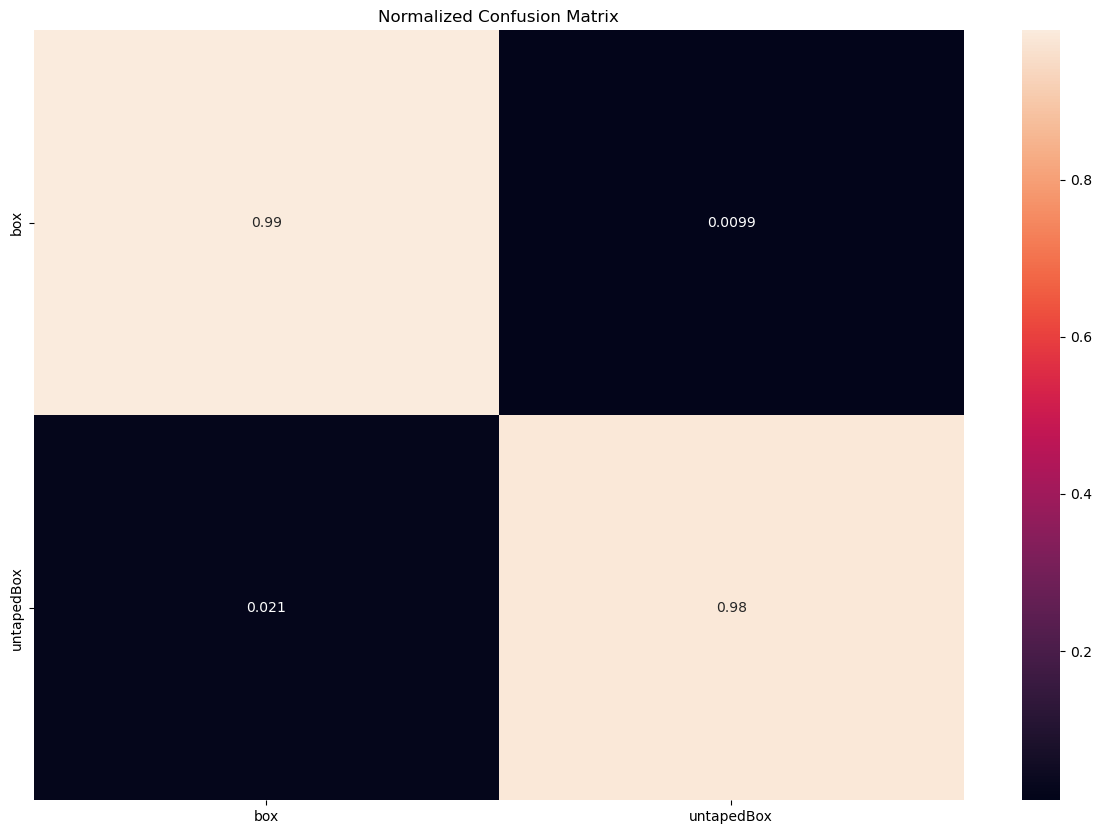

In [21]:
import seaborn as sns

test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
epoch_f1 = f1_score(test['label'], test['pred'], average='macro')
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')

test_matrix = confusion_matrix(test['label'], test['pred'], normalize='true')
#test_matrix = confusion_matrix(test['label'], test['pred'])

plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(test['label'])), 
            yticklabels = sorted(set(test['label'])),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')

In [23]:
test.to_csv('test_result/incep_res_0403.csv', index=False)

In [22]:
import json
import jsonlines
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import random

In [23]:
test['pred'].value_counts()

bottle            1229
dishes            1163
stairs             806
else               597
plug               593
battery            501
transportation     458
handkerchief       443
10Kwalk            411
pet                410
shopping bag       409
box                382
paper              374
milk               371
trash picking      325
receipt            288
Name: pred, dtype: int64

In [24]:
tmp_list = []
label = test[test.pred == 'else']

label.sort_values(by=['image_id'],ascending=True, inplace=True)
label.reset_index(inplace=True, drop=True)
tmp = label['image_id'].value_counts().index.sort_values()
label

/tmp/ipykernel_1475945/30508609.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  label.sort_values(by=['image_id'],ascending=True, inplace=True)


,image_id,dir,label,pred
0,10Kwalk_1047.jpg,../Data/carbon_data/10Kwalk,10Kwalk,else
1,10Kwalk_1174.jpg,../Data/carbon_data/10Kwalk,10Kwalk,else
2,16583193231991658319380893.jpg,../Data/carbon_data/else/instance_spoon,else,else
3,16583311864571658331260534.jpg,../Data/carbon_data/else/instance_spoon,else,else
4,20220722_125118_HDR1658461897787.jpg,../Data/carbon_data/else/instance_spoon,else,else
...,...,...,...,...
592,wrap_990.jpg,../Data/carbon_data/dishes/wrap,dishes,else
593,wrap_995.jpg,../Data/carbon_data/dishes/wrap,dishes,else
594,양치컵 사용_063.jpg,../Data/carbon_data/bottle/toothcup/toothcup_852,bottle,else
595,양치컵 사용_140.jpg,../Data/carbon_data/bottle/toothcup/toothcup_852,bottle,else


In [ ]:
## show img status

back = 0
plt.figure(figsize=(16,500))
for i in range(len(label[200:400])):
    plt.subplot(100,4,i+1)
    if i % 4 == 0:
        plt.title(f"{(i+1+back)/4}")
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    path = label['dir'][i] + '/' + label['image_id'][i]
    try:
    # im_bgr = cv2.imread(path)
    # im_rgb = im_bgr[:, :, ::-1]
        temp = Image.open(path).convert("RGB")
        image = np.array(temp).copy()
        temp.close()

        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(label['image_id'][i], loc='left', fontsize=10)
    except:
        plt.xlabel(path, loc='left', fontsize=10)
        
plt.show()